# From Coursera tutorial: Predict diabetes with a random forest using R
#### This is the .R script represented as a Jupyter notebook 

In [2]:
#load relevant libraries
library(neuralnet)
library(caret)
library(tidyverse)
library(mlbench)
library(e1071)

Warning message:
“package ‘neuralnet’ was built under R version 3.5.2”
Warning message:
“package ‘caret’ was built under R version 3.5.2”
Loading required package: lattice

Loading required package: ggplot2

Warning message:
“package ‘tidyverse’ was built under R version 3.5.2”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ dplyr   0.8.3
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.3     

Warning message:
“package ‘purrr’ was built under R version 3.5.2”
Warning message:
“package ‘dplyr’ was built under R version 3.5.2”
Warning message:
“package ‘stringr’ was built under R version 3.5.2”
Warning message:
“package ‘forcats’ was built under R version 3.5.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::compute() masks neuralnet::compute()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ purrr::lift()    masks caret:

In [3]:
#1) DATA LOADING
#load the PIMA dataset
df = read.csv("pima-indians-diabetes_MOD.csv")
str(df)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: int  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : int  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: int  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps : int  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin : int  0 0 0 94 168 0 88 0 543 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : int  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: int  1 0 1 0 1 0 1 0 1 1 ...


In [4]:
#I convert the data type of the columns as the tutorial
df$diabetes<-as.factor(df$diabetes) #2=1=positive, 1=0=negative
levels(df$diabetes) <- c("neg","pos")
df[, c(1:5,8)] <- sapply(df[, c(1:5,8)], as.numeric)
str(df)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps : num  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin : num  0 0 0 94 168 0 88 0 543 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


'data.frame':	768 obs. of  10 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps : num  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin : num  0 0 0 94 168 0 88 0 543 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...
 $ binary  : num  1 0 1 0 1 0 1 0 1 1 ...


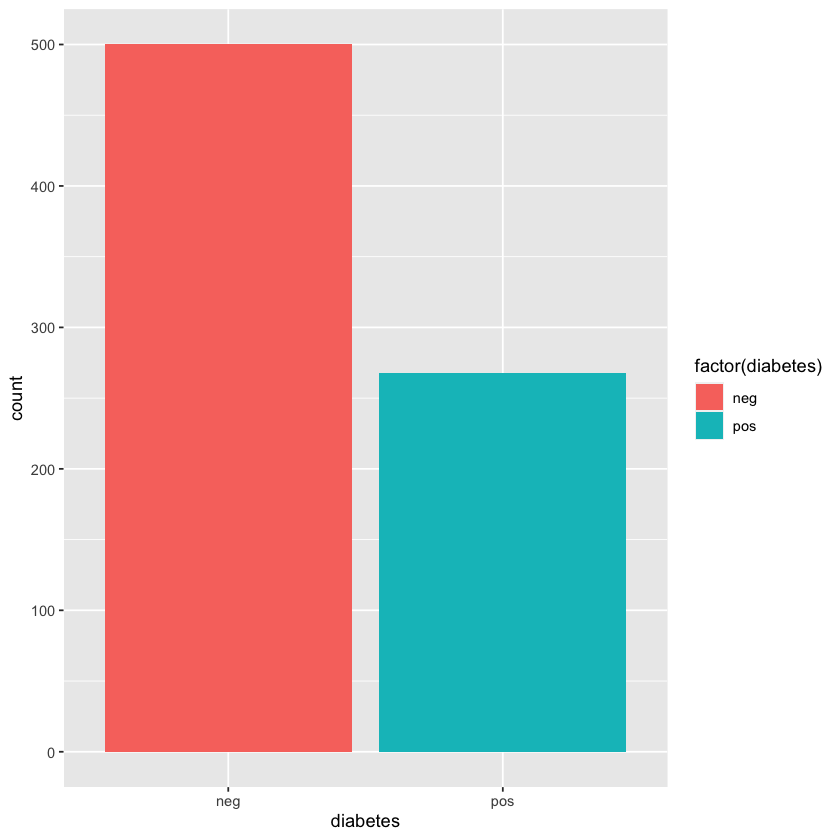

In [5]:
# 2) EXPLORATORY ANALYSIS
ggplot(df, aes(diabetes, fill = factor(diabetes)))+
  geom_bar()

df$binary <- ifelse(df$diabetes == 'neg', 0, 1)
str(df)

In [7]:
# 3) DATA PARTITION
# Creating the train (70%) and test (30%) sets

rows <- createDataPartition(df$binary, times = 1, p = 0.7, list = FALSE) 
# this contains 538 elements (70% of original df) and gives the row number of the original df which will
# be part of the train dataset

#subset the df
train <-df[rows,] 
test <-df[-rows,]
dim(train)
dim(test)

[1] 538  10

[1] 230  10

In [9]:
# 4) CREATING MODELS

#clean up the train and test datasets
names(train) #diabetes is the 9 variable in train and test dataframes
train<-train[,-9]
test<-test[,-9]
str(train) 
str(test) #now the diabetes var has been removed (it is the same as binary and it would 
# compromise the correlation step)


[1] "pregnant" "glucose"  "pressure" "triceps"  "insulin"  "mass"    
 [7] "pedigree" "age"      "diabetes" "binary"

'data.frame':	538 obs. of  9 variables:
 $ pregnant: num  6 1 5 2 8 4 7 0 1 1 ...
 $ glucose : num  148 85 116 197 125 110 100 118 103 115 ...
 $ pressure: num  72 66 74 70 96 92 0 84 30 70 ...
 $ triceps : num  35 29 0 45 0 0 0 47 38 30 ...
 $ insulin : num  0 0 0 543 0 0 0 230 83 96 ...
 $ mass    : num  33.6 26.6 25.6 30.5 0 37.6 30 45.8 43.3 34.6 ...
 $ pedigree: num  0.627 0.351 0.201 0.158 0.232 0.191 0.484 0.551 0.183 0.529 ...
 $ age     : num  50 31 30 53 54 30 32 31 33 32 ...
 $ binary  : num  1 0 0 1 1 0 1 1 0 1 ...
'data.frame':	230 obs. of  9 variables:
 $ pregnant: num  8 1 0 3 10 10 10 1 5 7 ...
 $ glucose : num  183 89 137 78 115 168 139 189 166 107 ...
 $ pressure: num  64 66 40 50 0 74 80 60 72 74 ...
 $ triceps : num  0 23 35 32 0 0 0 23 19 0 ...
 $ insulin : num  0 94 168 88 0 0 0 846 175 0 ...
 $ mass    : num  23.3 28.1 43.1 31 35.3 38 27.1 30.1 25.8 29.6 ...
 $ pedigree: num  0.672 0.167 2.288 0.248 0.134 ...
 $ age     : num  32 21 33 26 29 34 57 59 51 31 ...
 $

In [10]:
#set up the random forest model with caret
model<-train(as.factor(binary) ~ ., #'.' indicates we use as predictors all the other vars in train df
             data = train,
             method = "ranger", #algorithm used
             trControl = trainControl(method = "repeatedcv", number = 2, repeats = 2)) #Train control object

model

Random Forest 

538 samples
  8 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (2 fold, repeated 2 times) 
Summary of sample sizes: 268, 270, 269, 269 
Resampling results across tuning parameters:

  mtry  splitrule   Accuracy   Kappa    
  2     gini        0.7677012  0.4477555
  2     extratrees  0.7547073  0.4023862
  5     gini        0.7640045  0.4470002
  5     extratrees  0.7640079  0.4396168
  8     gini        0.7602939  0.4406579
  8     extratrees  0.7658839  0.4467919

Tuning parameter 'min.node.size' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 2, splitrule = gini
 and min.node.size = 1.

In [12]:
# 5) PREDICT USING A TEST SET

#predict outcome in both train and test sets
predict_train <- predict(model, train)
predict_test <- predict(model, test)

#create a confusion matrix for the TRAIN set
confusionMatrix(predict_train, as.factor(train$binary))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 363   0
         1   0 175
                                     
               Accuracy : 1          
                 95% CI : (0.9932, 1)
    No Information Rate : 0.6747     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.6747     
         Detection Rate : 0.6747     
   Detection Prevalence : 0.6747     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 0          
                                     

In [13]:
#create a confusion matrix for the TEST set
confusionMatrix(predict_test, as.factor(test$binary))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 124  47
         1  13  46
                                          
               Accuracy : 0.7391          
                 95% CI : (0.6773, 0.7946)
    No Information Rate : 0.5957          
    P-Value [Acc > NIR] : 3.706e-06       
                                          
                  Kappa : 0.4247          
                                          
 Mcnemar's Test P-Value : 2.042e-05       
                                          
            Sensitivity : 0.9051          
            Specificity : 0.4946          
         Pos Pred Value : 0.7251          
         Neg Pred Value : 0.7797          
             Prevalence : 0.5957          
         Detection Rate : 0.5391          
   Detection Prevalence : 0.7435          
      Balanced Accuracy : 0.6999          
                                          
       'Positive' Class : 0               
                              